<a href="https://colab.research.google.com/github/bedadiggelmann/bina/blob/main/BINA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import plotly.express as px
import json
import pandas as pd
import numpy as np
import seaborn as sns

# Helper Functions

Overpass Kanton St. Gallen Abfrage:
https://overpass-turbo.eu/

Gemeinden
```
[out:json];
area[name="St. Gallen"][boundary=administrative][admin_level=4];
rel(area)[boundary=administrative][admin_level=8];
out geom;

```



Wahlkreise
```
[out:json][timeout:25];
area["name"="St. Gallen"]["admin_level"="4"]->.kanton;
(
  relation(area.kanton)["name"~"Wahlkreis"];
);
out body;
>;
out skel qt;
```







**Data Loading Functions**

This script loads data from a CSV file. Ensure that the path and the encoding match the data file specifics.

In [43]:
def load_data(filepath, encoding='ISO-8859-1', delimiter=';'):
    return pd.read_csv(filepath, encoding=encoding, delimiter=delimiter)


def load_data(file_path, delimiter=';', encoding='latin1'):
    """
    Load a CSV file with the given path, delimiter, and encoding.
    """
    return pd.read_csv(file_path, delimiter=delimiter, encoding=encoding)

**Data Filtering Functions**

Filters the dataset for specific municipalities using a unique identifier contained in a column.

In [44]:
def filter_data_by_kanton_or_gemeinde(data, column_name, kanton_or_gemeinde_code):
    """
    Filter data by a specific Kanton or Gemeinde.
    """
    return data[data[column_name].str.contains(kanton_or_gemeinde_code)]

**Data Extraction Functions**

Extracts yearly data for given conditions and converts non-numeric entries appropriately.

In [45]:
def extract_yearly_data(gemeinde_data, condition_value, typ_value, start_col=4):
    """
    Extract yearly data for given conditions and convert non-numeric entries appropriately.
    """
    yearly_data = gemeinde_data[
        (gemeinde_data["Anzahl/Anteil"] == condition_value) &
        (gemeinde_data["Leerwohnung (Typ)"].str.contains(typ_value, na=False))
    ].iloc[:, start_col:]
    yearly_data = yearly_data.replace('...', pd.NA)  # Replace '...' with NaN
    yearly_data = yearly_data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, coercing errors
    years = yearly_data.columns.tolist()  # Get the list of years (column names)
    return yearly_data.iloc[0] if not yearly_data.empty else pd.Series([pd.NA] * len(years), index=years)

**Process and Aggregate Data Functions**

In [46]:
def map_municipalities_to_wahlkreis(csv_data):
    """
    Map municipalities to Wahlkreis.
    """
    wahlkreis_mapping = {
        'Altstätten': 'Rheintal',
        'Au': 'Rheintal',
        'Balgach': 'Rheintal',
        'Berneck': 'Rheintal',
        'Diepoldsau': 'Rheintal',
        'Eichberg': 'Rheintal',
        'Marbach': 'Rheintal',
        'Oberriet': 'Rheintal',
        'Rebstein': 'Rheintal',
        'Rheineck': 'Rheintal',
        'Rüthi': 'Rheintal',
        'St. Margrethen': 'Rheintal',
        'Widnau': 'Rheintal',
        'Berg': 'Rorschach',
        'Goldach': 'Rorschach',
        'Mörschwil': 'Rorschach',
        'Rorschach': 'Rorschach',
        'Rorschacherberg': 'Rorschach',
        'Steinach': 'Rorschach',
        'Thal': 'Rorschach',
        'Tübach': 'Rorschach',
        'Untereggen': 'Rorschach',
        'Bad Ragaz': 'Sarganserland',
        'Flums': 'Sarganserland',
        'Mels': 'Sarganserland',
        'Pfäfers': 'Sarganserland',
        'Quarten': 'Sarganserland',
        'Sargans': 'Sarganserland',
        'Vilters-Wangs': 'Sarganserland',
        'Walenstadt': 'Sarganserland',
        'Amden': 'See-Gaster',
        'Benken': 'See-Gaster',
        'Eschenbach': 'See-Gaster',
        'Gommiswald': 'See-Gaster',
        'Kaltbrunn': 'See-Gaster',
        'Rapperswil-Jona': 'See-Gaster',
        'Schänis': 'See-Gaster',
        'Schmerikon': 'See-Gaster',
        'Uznach': 'See-Gaster',
        'Weesen': 'See-Gaster',
        'Andwil': 'St. Gallen',
        'Eggersriet': 'St. Gallen',
        'Gaiserwald': 'St. Gallen',
        'Gossau': 'St. Gallen',
        'Häggenschwil': 'St. Gallen',
        'Muolen': 'St. Gallen',
        'St. Gallen': 'St. Gallen',
        'Waldkirch': 'St. Gallen',
        'Wittenbach': 'St. Gallen',
        'Bütschwil-Ganterschwil': 'Toggenburg',
        'Ebnat-Kappel': 'Toggenburg',
        'Kirchberg': 'Toggenburg',
        'Lichtensteig': 'Toggenburg',
        'Lütisburg': 'Toggenburg',
        'Mosnang': 'Toggenburg',
        'Neckertal': 'Toggenburg',
        'Nesslau': 'Toggenburg',
        'Wattwil': 'Toggenburg',
        'Wildhaus-Alt St. Johann': 'Toggenburg',
        'Buchs': 'Werdenberg',
        'Gams': 'Werdenberg',
        'Grabs': 'Werdenberg',
        'Sennwald': 'Werdenberg',
        'Sevelen': 'Werdenberg',
        'Wartau': 'Werdenberg',
        'Degersheim': 'Wil',
        'Flawil': 'Wil',
        'Jonschwil': 'Wil',
        'Niederbüren': 'Wil',
        'Niederhelfenschwil': 'Wil',
        'Oberbüren': 'Wil',
        'Oberuzwil': 'Wil',
        'Uzwil': 'Wil',
        'Wil': 'Wil',
        'Zuzwil': 'Wil'
    }

    # Function to map a single row based on the presence of the key in the string
    def map_row(row):
        for key, value in wahlkreis_mapping.items():
            if key in row:
                return value
        return None

    # Update the dataset with a new column for Wahlkreis based on the mapping
    csv_data['Wahlkreis'] = csv_data['Grossregion (<<) / Kanton (-) / Gemeinde (......)'].apply(map_row)
    return csv_data

def sum_data_by_wahlkreis_or_gemeinde(csv_data):
    """
    Sum up data by Wahlkreis for specific rows.
    """
    filtered_data = csv_data[
        (csv_data.iloc[:, 1] == 'Anzahl Wohnräume - Total') &
        (csv_data.iloc[:, 2] == 'Leer stehende Wohnung - Total') &
        (csv_data.iloc[:, 3] == 'Anzahl')
    ]

    numeric_columns = filtered_data.columns[4:-1]
    filtered_data.loc[:, numeric_columns] = filtered_data.loc[:, numeric_columns].apply(pd.to_numeric, errors='coerce')

    summed_data = filtered_data.groupby('Wahlkreis')[numeric_columns].sum()
    return summed_data


def process_wahlkreise_and_gemeinde_data(file_path):
    """
    Process the Wahlkreise data to sum apartments per Wahlkreis for each year.
    """
    data = load_data(file_path)

    # Find the rows that belong to the Wahlkreise (>> Wahlkreis)
    wahlkreise = data[data['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.startswith('>>')]

    # Remove the first two characters (>>) and the word 'Wahlkreis ' from the Wahlkreis name
    wahlkreise['Kanton (-) / Bezirk (>>) / Gemeinde (......)'] = wahlkreise['Kanton (-) / Bezirk (>>) / Gemeinde (......)'].str.replace('>> Wahlkreis ', '')

    # Define the years that are in the columns
    years = data.columns[4:]

    # Sum the apartments per Wahlkreis for each year
    anzahl_wohnungen_pro_wahlkreis = wahlkreise.groupby('Kanton (-) / Bezirk (>>) / Gemeinde (......)')[years].sum()

    # Set the column 'Wahlkreis' as the index
    anzahl_wohnungen_pro_wahlkreis.index.name = 'Wahlkreis'

    # Set the index column as the first column
    anzahl_wohnungen_pro_wahlkreis.reset_index(inplace=True)

    return anzahl_wohnungen_pro_wahlkreis


# List of city municipalities in the canton of St. Gallen
staedtische_gemeinden = [
    'Altstätten', 'Buchs (SG)', 'Flawil', 'Gossau (SG)', 'Rapperswil-Jona',
    'Rorschach', 'St. Gallen', 'Uzwil', 'Wil (SG)'
]

# Function to categorize municipalities
def categorize_gemeinde(gemeinde):
    if any(city in gemeinde for city in staedtische_gemeinden):
        return 'städtisch'
    else:
        return 'ländlich'

**Calculation Functions**

Functions to calculate stuff.


In [47]:
def calculate_vacancy_rate(anzahl_wohnungen_path, anzahl_leerwohnungen_path, output_file_path):
    """
    Calculate the vacancy rate and save the results to a new CSV file.
    """
    anzahl_wohnungen = load_data(anzahl_wohnungen_path, delimiter=',')
    anzahl_leerwohnungen = load_data(anzahl_leerwohnungen_path, delimiter=',')

    # Set the Wahlkreis as the index to merge the tables
    anzahl_wohnungen.set_index('Wahlkreis', inplace=True)
    anzahl_leerwohnungen.set_index('Wahlkreis', inplace=True)

    # Calculate the vacancy rate (Vacant apartments / Total apartments * 100)
    leerwohnungsziffer = (anzahl_leerwohnungen / anzahl_wohnungen) * 100

    # Rename the columns to indicate that they represent the vacancy rate
    leerwohnungsziffer.columns = [col for col in leerwohnungsziffer.columns]

    # Set the index column as the first column
    leerwohnungsziffer.reset_index(inplace=True)

    # Save the results to a new CSV file
    leerwohnungsziffer.to_csv(output_file_path, index=False)

    return leerwohnungsziffer

**Plotting Functions**

Functions to plot time series and bar charts for visual comparisons.

In [48]:
def plot_line_chart(data_dict, title, xlabel, ylabel, start_year=None, end_year=None):
    """
    Plot a line chart for visual comparisons.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    for label, data in data_dict.items():
        if start_year and end_year:
            data = data.loc[str(start_year):str(end_year)]
        ax.plot(data.index, data.values, label=label, marker='o')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

def plot_bar_chart(data_dict, title, xlabel, ylabel, start_year=None, end_year=None):
    """
    Plot a bar chart for visual comparisons.
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    for label, data in data_dict.items():
        if start_year and end_year:
            data = data.loc[str(start_year):str(end_year)]
        positions = range(len(data.index))
        ax.bar(positions, data.values, label=label)
        ax.set_title(title)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_ylim([0, 3])
        ax.set_xticks(range(len(data.index)))
        ax.set_xticklabels(data.index, rotation=45)
        ax.legend()
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

def plot_multi_panel_chart(data, title, xlabel, ylabel, ncols=4, y_max=4.0, start_year=2010, end_year=2022):
    """
    Plot multiple subplots in a grid layout for visual comparisons.
    """
    # Filter the data to include only the specified range of years
    years = [str(year) for year in range(start_year, end_year + 1)]
    data = {label: series[years] for label, series in data.items()}

    # Determine the number of rows and columns based on the data
    num_plots = len(data)
    nrows = (num_plots + ncols - 1) // ncols

    # Plotting the multi-panel graphic
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 10), sharex=True, sharey=True)
    fig.suptitle(title, fontsize=24, y=1.02)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate over each item in data and plot it
    for i, (label, series) in enumerate(data.items()):
        if i >= len(axes):
            break
        ax = axes[i]
        ax.plot(series.index, series.values, marker='o')
        ax.set_title(label)
        ax.set_xticks(range(len(series.index)))
        ax.set_xticklabels(series.index, rotation=45)
        ax.set_ylim(0, y_max)
        ax.grid(True)

    # Remove empty subplots
    for ax in axes[num_plots:]:
        fig.delaxes(ax)

    # Set common labels
    fig.text(0.5, 0.04, xlabel, ha='center', fontsize=16)
    fig.text(0.04, 0.5, ylabel, va='center', rotation='vertical', fontsize=16)

    plt.tight_layout(rect=[0.05, 0.05, 1, 0.95])
    plt.show()

def plot_box_chart(data, title, xlabel, ylabel, start_year=None, end_year=None, ylim=(0, 10)):
    """
    Plot a box chart for visual comparisons.
    """
    if start_year and end_year:
        data = data[(data['Jahr'] >= start_year) & (data['Jahr'] <= end_year)]

    plt.figure(figsize=(14, 7))
    boxplot = sns.boxplot(data=data, x=xlabel, y=ylabel)
    plt.ylim(ylim)

    # Median line
    categories = data[xlabel].unique()
    for category in categories:
        median = data[data[xlabel] == category][ylabel].median()
        color = 'blue' if category == 'ländlich' else 'orange'
        boxplot.axhline(y=median, color=color, linestyle='--', label=f'Median {category}')

    # Add labels
    boxplot.set_title(title)
    boxplot.set_xlabel(xlabel)
    boxplot.set_ylabel(ylabel)

    # Legend
    plt.legend(title='Legende', loc='upper right')

    # Label percentiles and relevant parts of the boxplot
    percentiles = [25, 50, 75]
    for i, category in enumerate(categories):
        for p in percentiles:
            percentile_value = data[data[xlabel] == category][ylabel].quantile(p / 100.0)
            plt.text(x=i-0.2, y=percentile_value, s=f'{p}%', color='black')

    # Display the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_scatter_chart(data, title, xlabel, ylabel, hue, start_year=None, end_year=None):
    """
    Plot a scatter chart for visual comparisons.
    """
    if start_year and end_year:
        data = data[(data['Jahr'] >= start_year) & (data['Jahr'] <= end_year)]

    plt.figure(figsize=(14, 7))
    scatter = sns.scatterplot(data=data, x=xlabel, y=ylabel, hue=hue)
    scatter.set_title(title)
    scatter.set_xlabel(xlabel)
    scatter.set_ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Set the x-axis to show every year
    plt.xticks(ticks=range(data[xlabel].min(), data[xlabel].max() + 1, 1), rotation=45)
    plt.show()

def plot_heatmap(data, title, col1, col2, vmax=5, start_year=None, end_year=None):
    """
    Plot a heatmap for visual comparisons.
    """
    if start_year and end_year:
        data = data[(data['Jahr'] >= start_year) & (data['Jahr'] <= end_year)]

    heatmap_data = data.pivot_table(index='Jahr', columns=col1, values=col2, aggfunc='mean').fillna(0)
    plt.figure(figsize=(12, 8))
    sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlGnBu", vmin=0, vmax=vmax)
    plt.title(title)
    plt.show()

# Usage



**1. Load and Filter Data**

Load and filter data for each municipality and the canton.

In [49]:
# Load data
leerwohnungszahlen_gemeinden_kt_stgallen = load_data('leerwohnungszahlen_gemeinden_kt_stgallen.csv')
leerwohnungszahlen_kt_stgallen = load_data('leerwohnungszahlen_kt_stgallen.csv')

# Filter data for kanton
kanton_sg_data = filter_data_by_kanton_or_gemeinde(leerwohnungszahlen_kt_stgallen, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', 'Kanton St. Gallen')

**2. Map Municipalities to Wahlkreis**

In [50]:
leerwohnungszahlen_with_wahlkreis = map_municipalities_to_wahlkreis(leerwohnungszahlen_gemeinden_kt_stgallen)

**3. Sum Data by Wahlkreis**

In [51]:
# Sum up data by Wahlkreis for specific rows
anzahl_leerwohnungen_pro_wahlkreis = sum_data_by_wahlkreis_or_gemeinde(leerwohnungszahlen_with_wahlkreis)

# Save the summed data
summed_csv_path = 'anzahl_leerwohnungen_pro_wahlkreis.csv'
anzahl_leerwohnungen_pro_wahlkreis.to_csv(summed_csv_path, index=True)


**4. Process Wahlkreise Data**

In [52]:
# Process the Wahlkreise data
file_path = 'wohnungen_wahlkreise_kt_stgallen.csv'
anzahl_wohnungen_pro_wahlkreis = process_wahlkreise_and_gemeinde_data(file_path)

# Save the results to a new CSV file
output_file_path = 'anzahl_wohnungen_pro_wahlkreis.csv'
anzahl_wohnungen_pro_wahlkreis.to_csv(output_file_path, index=False)

**5. Calculate Vacancy Rate**

In [53]:
# Calculate vacancy rate and save the results
output_file_path = 'calculated_leerwohnungsziffer_pro_wahlkreis.csv'
leerwohnungsziffer = calculate_vacancy_rate('anzahl_wohnungen_pro_wahlkreis.csv', 'anzahl_leerwohnungen_pro_wahlkreis.csv', output_file_path)

# Output the results for verification
leerwohnungsziffer.head()

Wahlkreis  1995  1996  1997  1998  1999  2000  2001  2002  2003  ...  \
0       Rheintal   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
1      Rorschach   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
2  Sarganserland   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
3     See-Gaster   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   
4     St. Gallen   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  ...   

       2014      2015      2016      2017      2018      2019      2020  \
0  2.558354  2.362940  2.205644  2.286479  2.394217  2.416503  2.472703   
1  2.501325  2.877835  2.724156  2.495693  2.846665  2.544714  3.191300   
2  0.826596  0.841092  0.892347  1.079829  1.246591  1.013687  1.653411   
3  1.282173  1.389932  1.443019  1.646916  1.850739  2.181527  2.156484   
4  1.420585  1.856276  1.825895  1.851077  2.238116  2.385559  2.821515   

       2021      2022  2023  
0  2.274471  1.699824   NaN  
1  2.598380  2.138591   NaN  
2  1.201953  0.864183   NaN  
3  1.690068  1.365671   NaN  
4  2.514764  2.319155   NaN  

[5 rows x 30 columns]

**6. Plot map of Kanton St. Gallen**

Plotting Kanton St. Gallen with all Wahlkreise and the Leerwohnungsziffer.

In [54]:
# Load the GeoJSON data
geojson_path = 'kanton_stgallen_wahlkreise.geojson'
gdf = gpd.read_file(geojson_path)

# Remove the prefix "Wahlkreis " from the 'name' column in the GeoDataFrame
gdf['name'] = gdf['name'].str.replace('Wahlkreis ', '')

# Load the data from CSV
file_path = 'calculated_leerwohnungsziffer_pro_wahlkreis.csv'
data = pd.read_csv(file_path)

# Reshape the data to long format
data_long = pd.melt(data, id_vars=['Wahlkreis'], var_name='year', value_name='leerwohnungsziffer')

# Ensure the 'year' column is of type int
data_long['year'] = data_long['year'].astype(int)

# Filter the data to only include years 2010 to 2022
data_long = data_long[(data_long['year'] >= 2010) & (data_long['year'] <= 2022)]

# Convert the year column to string to avoid decimal points in the slider
data_long['year'] = data_long['year'].astype(str)

# Merge the GeoDataFrame with the data
merged_gdf = gdf.merge(data_long, left_on='name', right_on='Wahlkreis', how='left')

# Extract the '@id' property and add it as a column
merged_gdf['id'] = merged_gdf['@id'] if '@id' in merged_gdf.columns else merged_gdf.index.astype(str)

# Calculate the box center of the GeoDataFrame
bounds = merged_gdf.total_bounds
center_lat = (bounds[1] + bounds[3]) / 2
center_lon = (bounds[0] + bounds[2]) / 2

# Ensure the GeoJSON data is in the correct format
with open(geojson_path) as f:
    geojson_data = json.load(f)

# Create the map
fig = px.choropleth_mapbox(
    merged_gdf,
    geojson=geojson_data,
    locations='id',
    featureidkey="properties.@id",  # Use the '@id' property as the unique identifier
    color='leerwohnungsziffer',
    animation_frame='year',
    hover_name='name',  # Use the 'name' column for Wahlkreise
    mapbox_style="carto-positron",
    center={"lat": center_lat, "lon": center_lon},
    zoom=8.5,
    opacity=0.5,
    color_continuous_scale=px.colors.sequential.Blues,
    range_color=(0, 3),
    labels={'leerwohnungsziffer': 'Leerwohnungsziffer in %', 'year': 'Jahr'},
    hover_data={'id': False}
)

# Update the layout to ensure the map displays correctly
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(
    title="Leerwohnungsziffer in den Wahlkreisen des Kantons St. Gallen",
    title_x=0.5,
    margin={"r":0,"t":0,"l":0,"b":0},
    height=800,
    sliders=[{
        'currentvalue': {"prefix": "Jahr: "}
    }]
)

# Display the map
fig.show()


**7. Plot Bar Chart of Leerwohnungsziffer of Kanton St. Gallen**

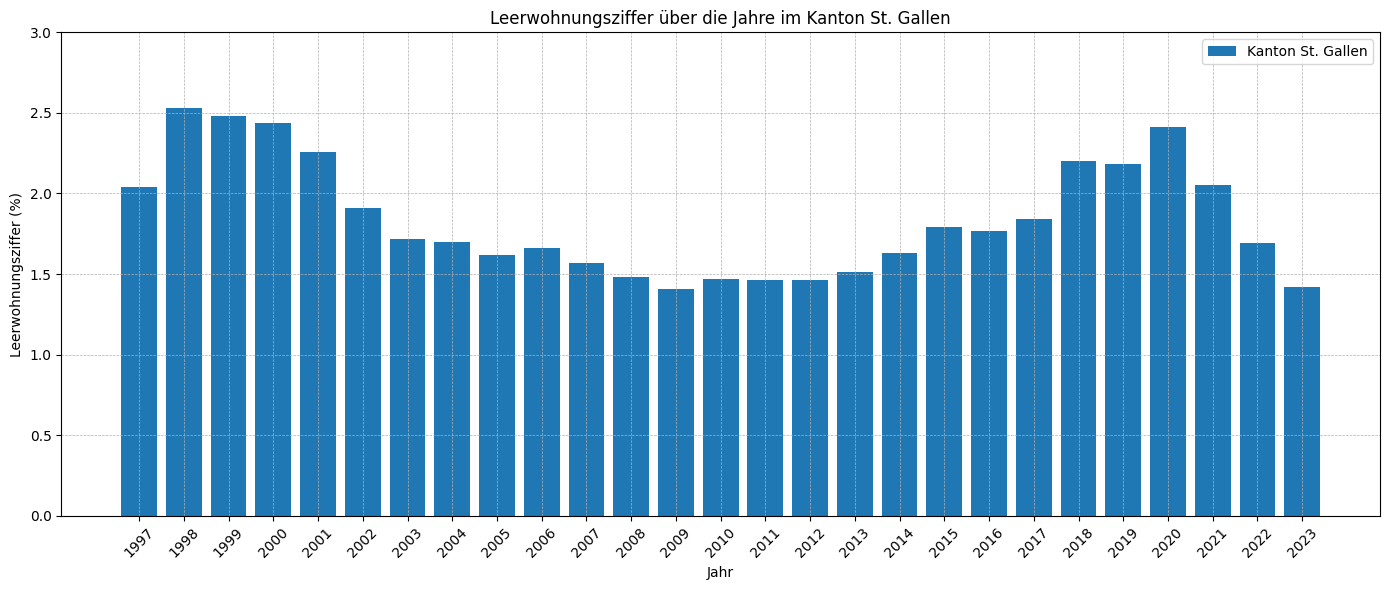

In [55]:
# Get Leerwohnungsziffer
kanton_sg_leerwohnungsziffer = extract_yearly_data(
    kanton_sg_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

# Leerwohnungsziffer über die Jahre
plot_bar_chart(
    {
        'Kanton St. Gallen': kanton_sg_leerwohnungsziffer
    },
    'Leerwohnungsziffer über die Jahre im Kanton St. Gallen',
    'Jahr',
    'Leerwohnungsziffer (%)',
    start_year=1997,
    end_year=2023
)

**8. Plot Multi-panel Bar Chart of Leerwohnungsziffer of Wahlkreise**

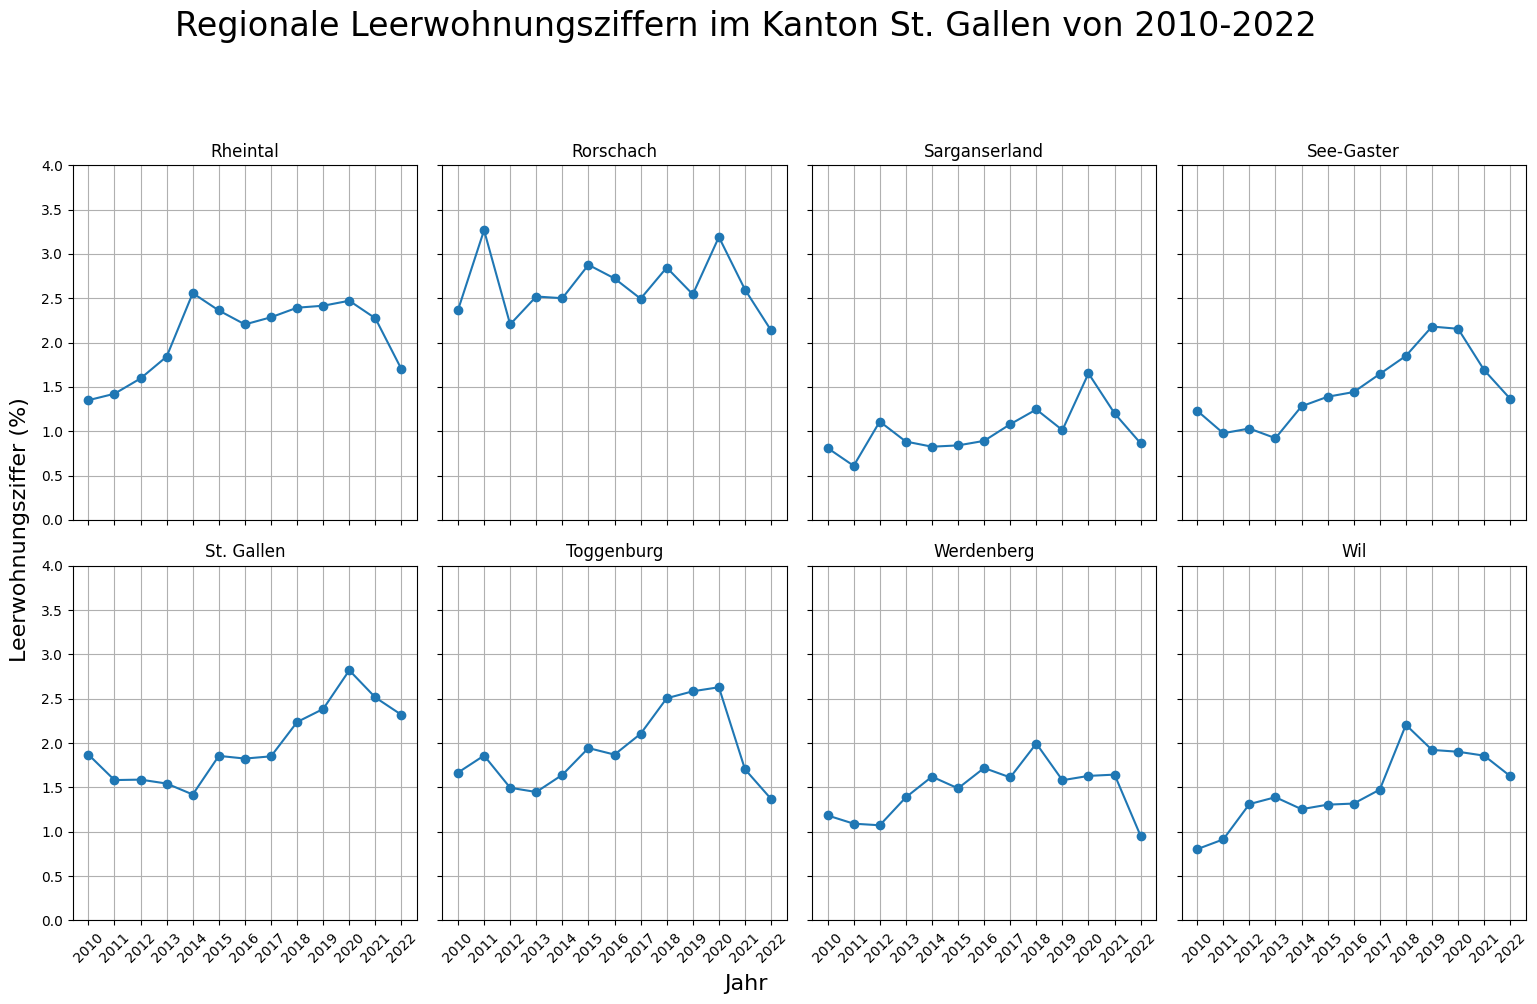

In [56]:
# Load data from the CSV file
leerwohnungsziffer = pd.read_csv('calculated_leerwohnungsziffer_pro_wahlkreis.csv')

# Prepare data for plotting
data_dict = {row['Wahlkreis']: row[1:] for _, row in leerwohnungsziffer.iterrows()}

# Call the plotting function
plot_multi_panel_chart(data_dict, 'Regionale Leerwohnungsziffern im Kanton St. Gallen von 2010-2022', 'Jahr', 'Leerwohnungsziffer (%)')


**OLD:**

**7. Extract Leerwohnungsanzahl and Leerwohnungsziffer for municipalities**


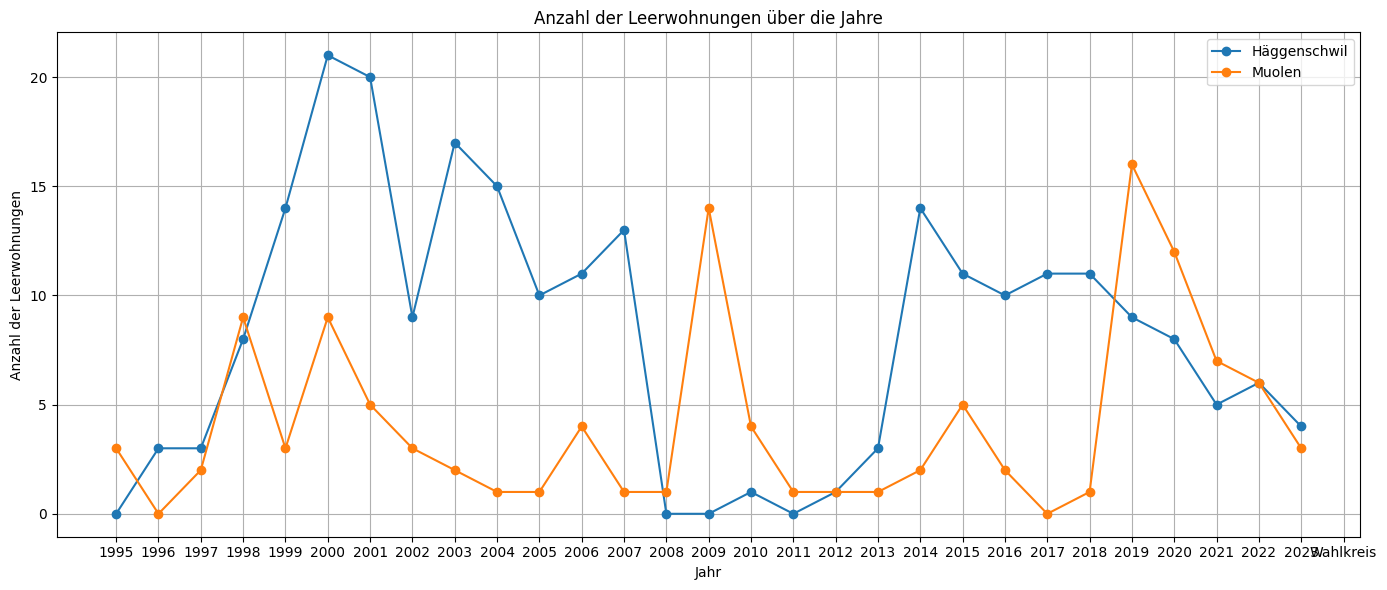

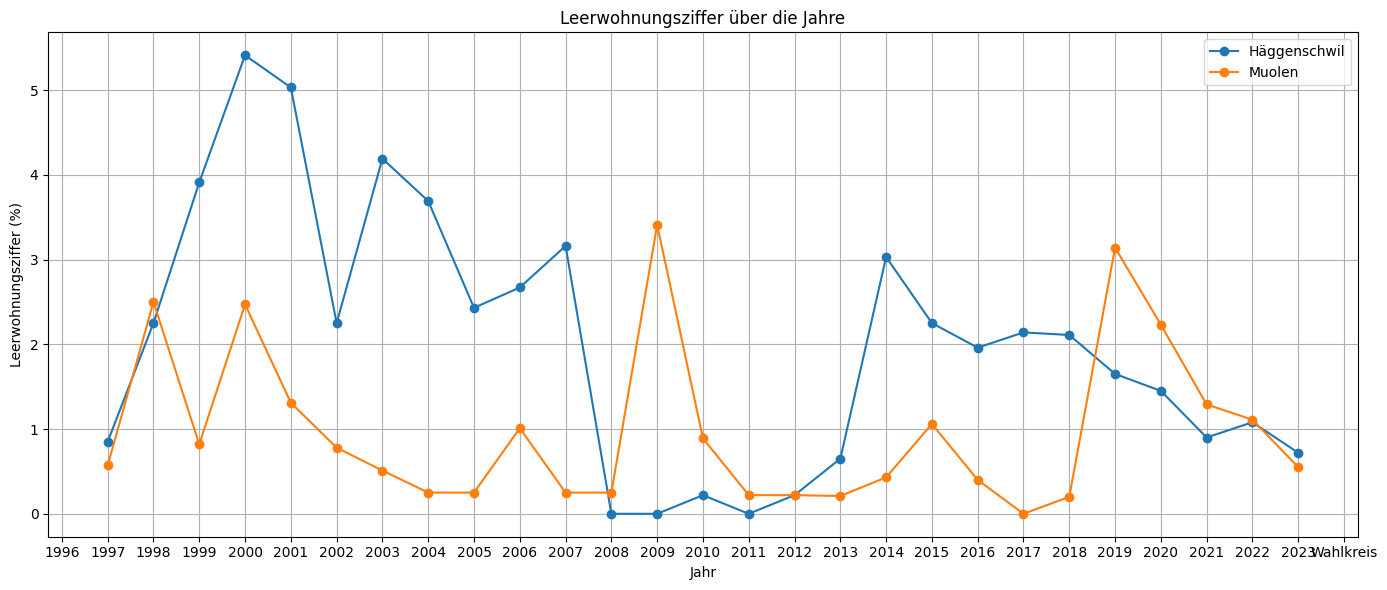

In [57]:

gemeinde_haeggenschwil_data = filter_data_by_kanton_or_gemeinde(leerwohnungszahlen_gemeinden_kt_stgallen, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', 'Häggenschwil')
gemeinde_muolen_data = filter_data_by_kanton_or_gemeinde(leerwohnungszahlen_gemeinden_kt_stgallen, 'Grossregion (<<) / Kanton (-) / Gemeinde (......)', 'Muolen')


# Leerwohnungsanzahl
haeggenschwil_leerwohnungsanzahl  = extract_yearly_data(
    gemeinde_haeggenschwil_data,
    "Anzahl",
    "Leer stehende Wohnung - Total"
    )

muolen_leerwohnungsanzahl = extract_yearly_data(
    gemeinde_muolen_data,
    "Anzahl",
    "Leer stehende Wohnung - Total"
    )


# Leerwohnungsziffer
haeggenschwil_leerwohnungsziffer = extract_yearly_data(
    gemeinde_haeggenschwil_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

muolen_leerwohnungsziffer = extract_yearly_data(
    gemeinde_muolen_data,
    'Leerwohnungsziffer',
    'Leer stehende Wohnung - Total'
)

# Anzahl der Leerwohnungen über die Jahre
plot_line_chart(
    {
        'Häggenschwil': haeggenschwil_leerwohnungsanzahl,
        'Muolen': muolen_leerwohnungsanzahl
    },
    'Anzahl der Leerwohnungen über die Jahre',
    'Jahr',
    'Anzahl der Leerwohnungen'
)



plot_line_chart(
    {
        'Häggenschwil': haeggenschwil_leerwohnungsziffer,
        'Muolen': muolen_leerwohnungsziffer
    },
    'Leerwohnungsziffer über die Jahre',
    'Jahr',
    'Leerwohnungsziffer (%)'
)


Basierend auf der [Statistik der Schweizer Städte 2024](https://www.bfs.admin.ch/bfs/de/home.agendadetail.2024-0276.html) werden die folgenden Gemeinden im Kanton St. Gallen als Städte anerkannt:

* Altstätten
* Buchs (SG)
* Flawil
* Gossau (SG)
* Rapperswil-Jona
* Rorschach
* St. Gallen
* Uzwil
* Wil (SG)

Dies sind die Gemeinden, die laut Definition des Bundesamtes für Statistik (BFS) die Kriterien für eine Stadt erfüllen.

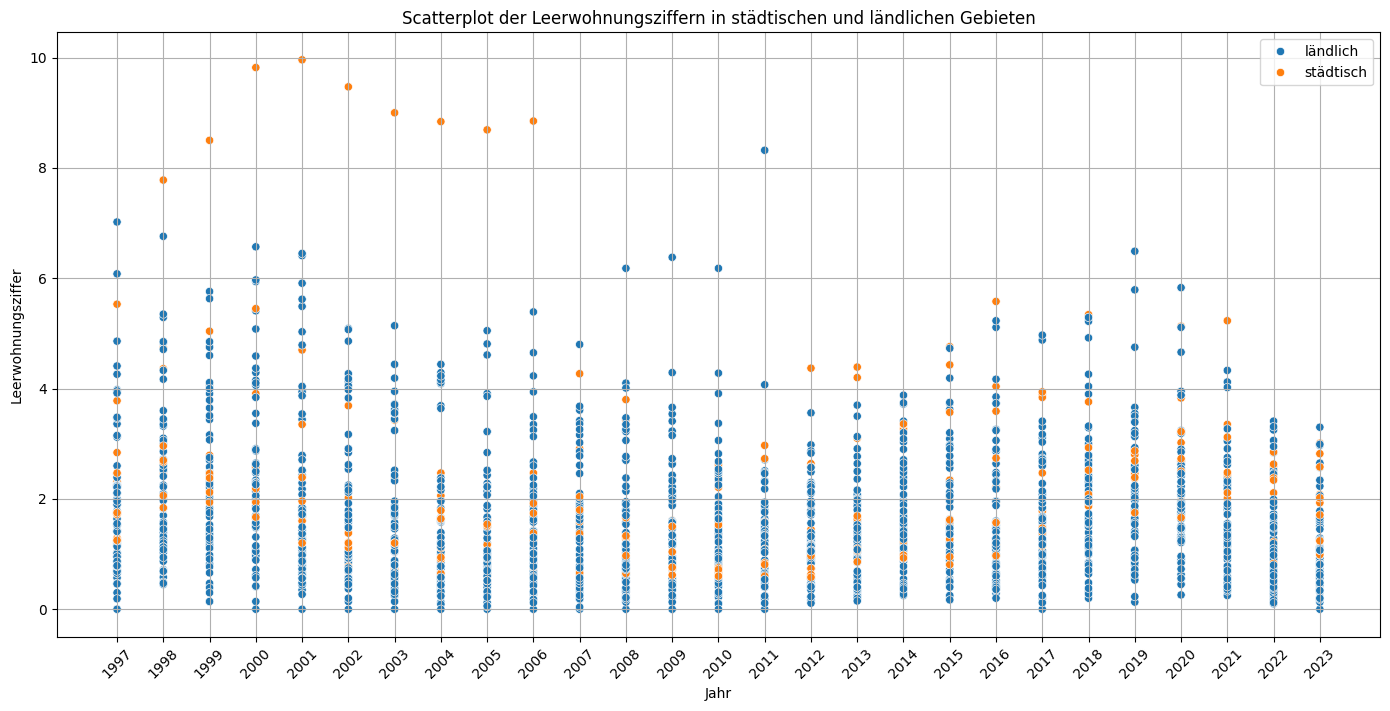

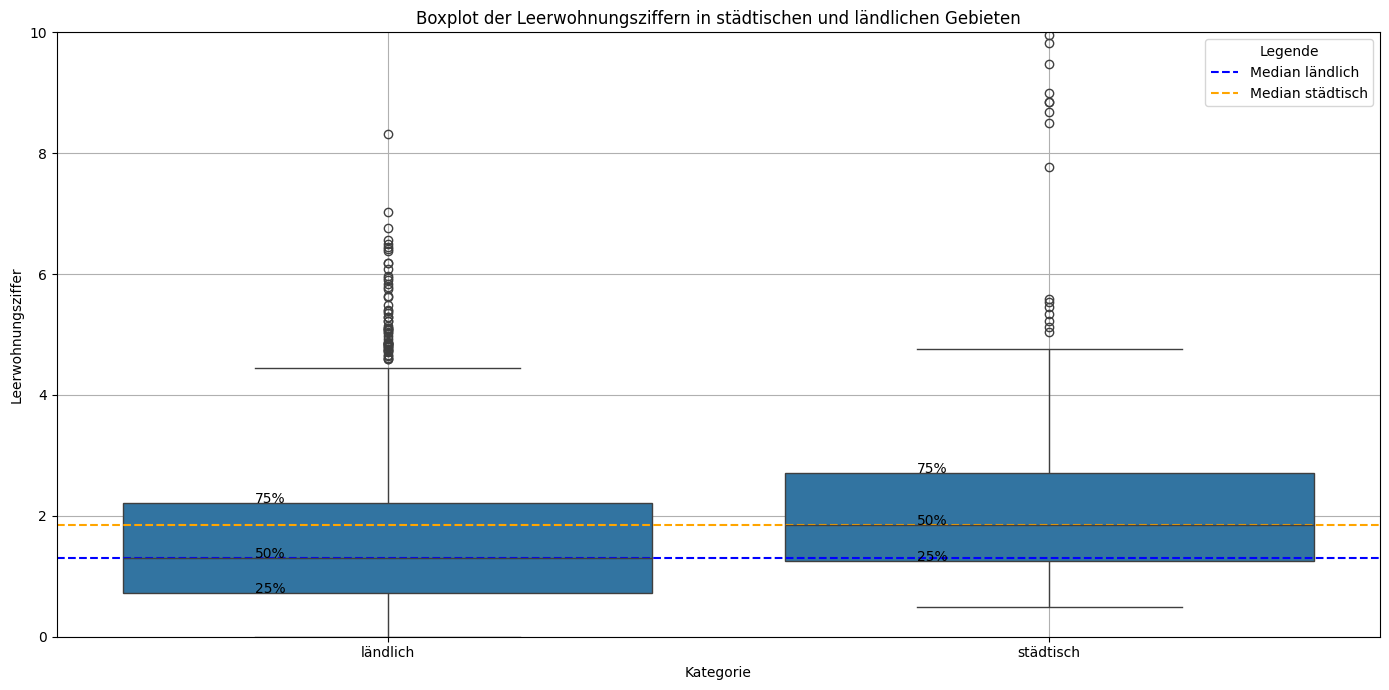

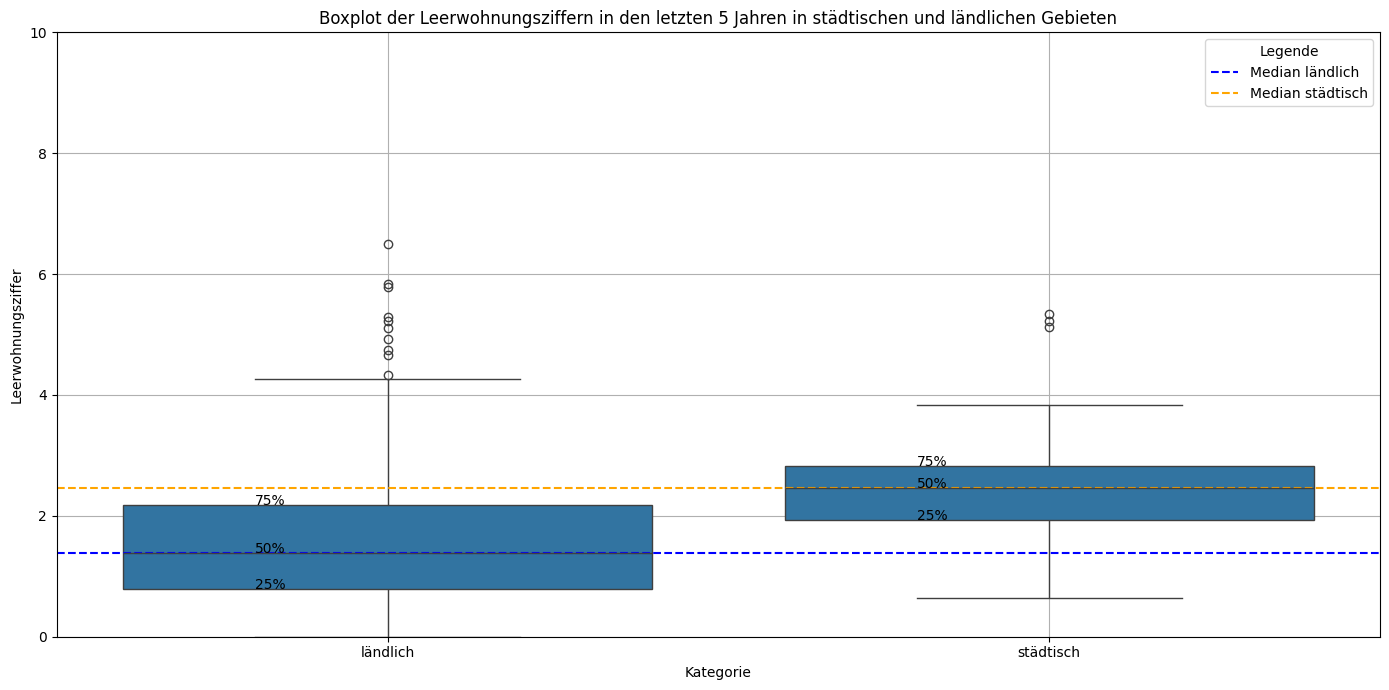

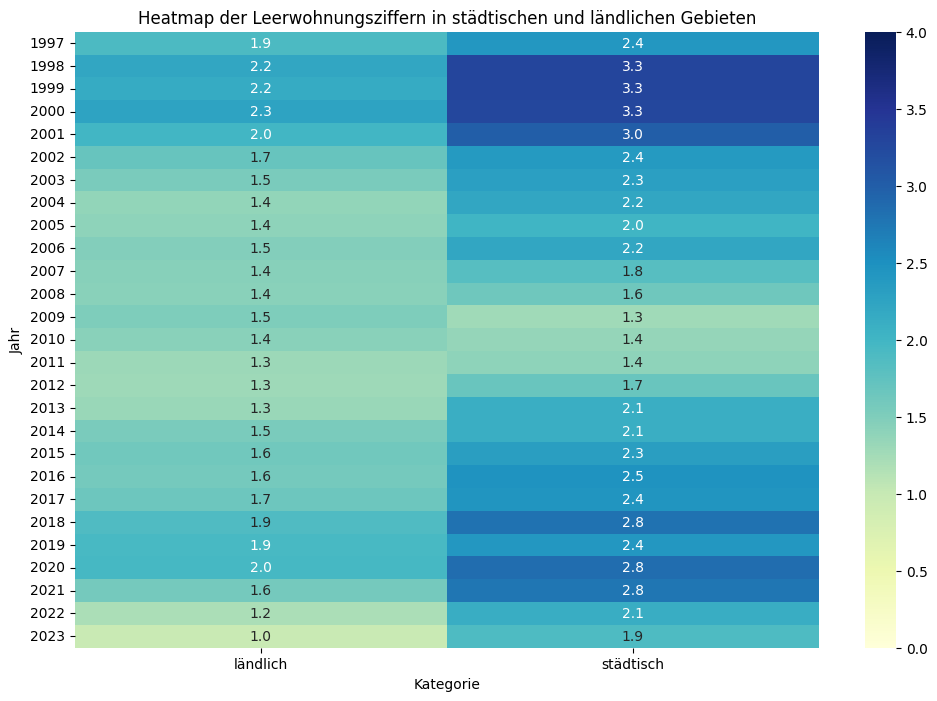

In [58]:
# Initialize a dictionary to store vacancy rates
leerwohnungsziffer_dict = {}

# Iterate through all municipalities in the dataset and extract vacancy rates
for gemeinde in leerwohnungszahlen_gemeinden_kt_stgallen['Grossregion (<<) / Kanton (-) / Gemeinde (......)'].unique():
    gemeinde_data = leerwohnungszahlen_gemeinden_kt_stgallen[leerwohnungszahlen_gemeinden_kt_stgallen['Grossregion (<<) / Kanton (-) / Gemeinde (......)'].str.contains(gemeinde, regex=False)]
    extracted_data = extract_yearly_data(gemeinde_data, 'Leerwohnungsziffer', 'Leer stehende Wohnung - Total')
    if gemeinde not in leerwohnungsziffer_dict:
        leerwohnungsziffer_dict[gemeinde] = extracted_data

# Categorize the data and combine into a DataFrame
data_list = []

for gemeinde, data in leerwohnungsziffer_dict.items():
    category = categorize_gemeinde(gemeinde)
    for year, ziffer in data.items():
        data_list.append({
            'Jahr': year,
            'Gemeinde': gemeinde,
            'Leerwohnungsziffer': ziffer,
            'Kategorie': category
        })

gesamt_df = pd.DataFrame(data_list)

# Cleaning: Remove rows with invalid years
gesamt_df = gesamt_df[gesamt_df['Jahr'].apply(lambda x: str(x).isdigit())]
gesamt_df['Jahr'] = gesamt_df['Jahr'].astype(int)

# Plotting the scatter plot of vacancy rates
plot_scatter_chart(gesamt_df, 'Scatterplot der Leerwohnungsziffern in städtischen und ländlichen Gebieten', 'Jahr', 'Leerwohnungsziffer', 'Kategorie', start_year=1997, end_year=2023)

# Boxplot of vacancy rates in urban and rural areas
plot_box_chart(gesamt_df, 'Boxplot der Leerwohnungsziffern in städtischen und ländlichen Gebieten', 'Kategorie', 'Leerwohnungsziffer', start_year=1997, end_year=2023)

# Boxplot of vacancy rates in urban and rural areas for the last 5 years (2017-2022)
plot_box_chart(gesamt_df, 'Boxplot der Leerwohnungsziffern in den letzten 5 Jahren in städtischen und ländlichen Gebieten', 'Kategorie', 'Leerwohnungsziffer', start_year=2018, end_year=2023)

# Heatmap of vacancy rates in urban and rural areas
# Could be misleading since we show the average percentage for each year of the group ländlich and städtisch
plot_heatmap(gesamt_df, 'Heatmap der Leerwohnungsziffern in städtischen und ländlichen Gebieten', 'Kategorie', 'Leerwohnungsziffer', vmax=4, start_year=1997, end_year=2023)

Population DataFrame head (first 10 rows):
    BFS_NR          GEBIET_NAME   THEMA_NAME             SET_NAME  \
0     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
1     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
2     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
3     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
4     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
5     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
6     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
7     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
8     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
9     1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
10    1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
11    1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbestand   
12    1721  Wahlkreis St.Gallen  Bevölkerung  Bevölkerungsbe

<ipython-input-69-f7ecf3facb11>:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-69-f7ecf3facb11>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-69-f7ecf3facb11>:50: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



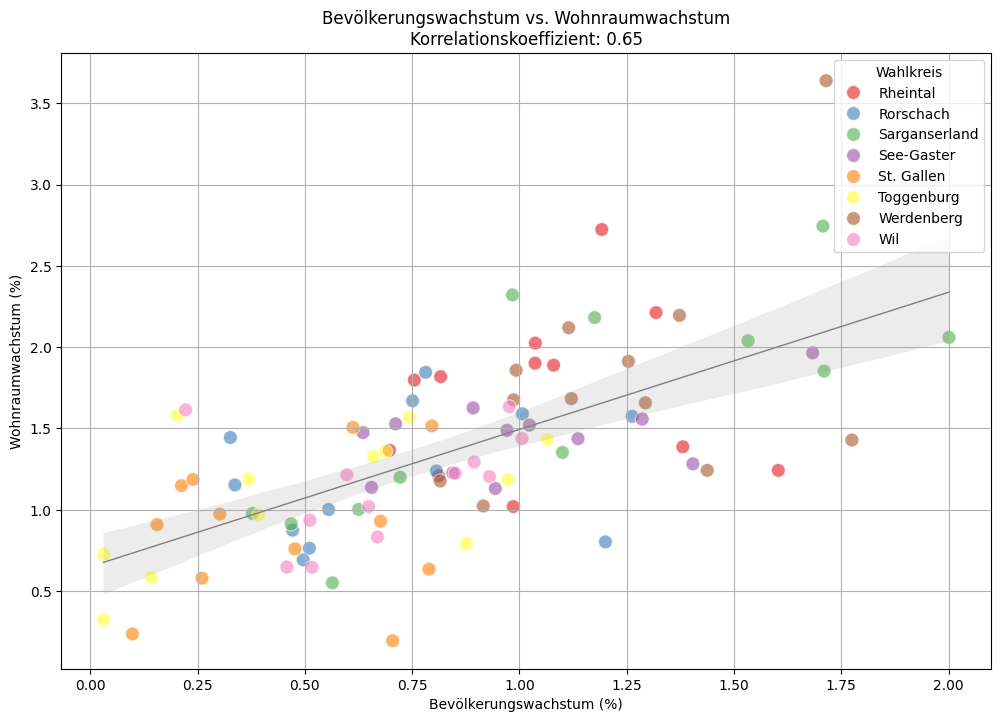

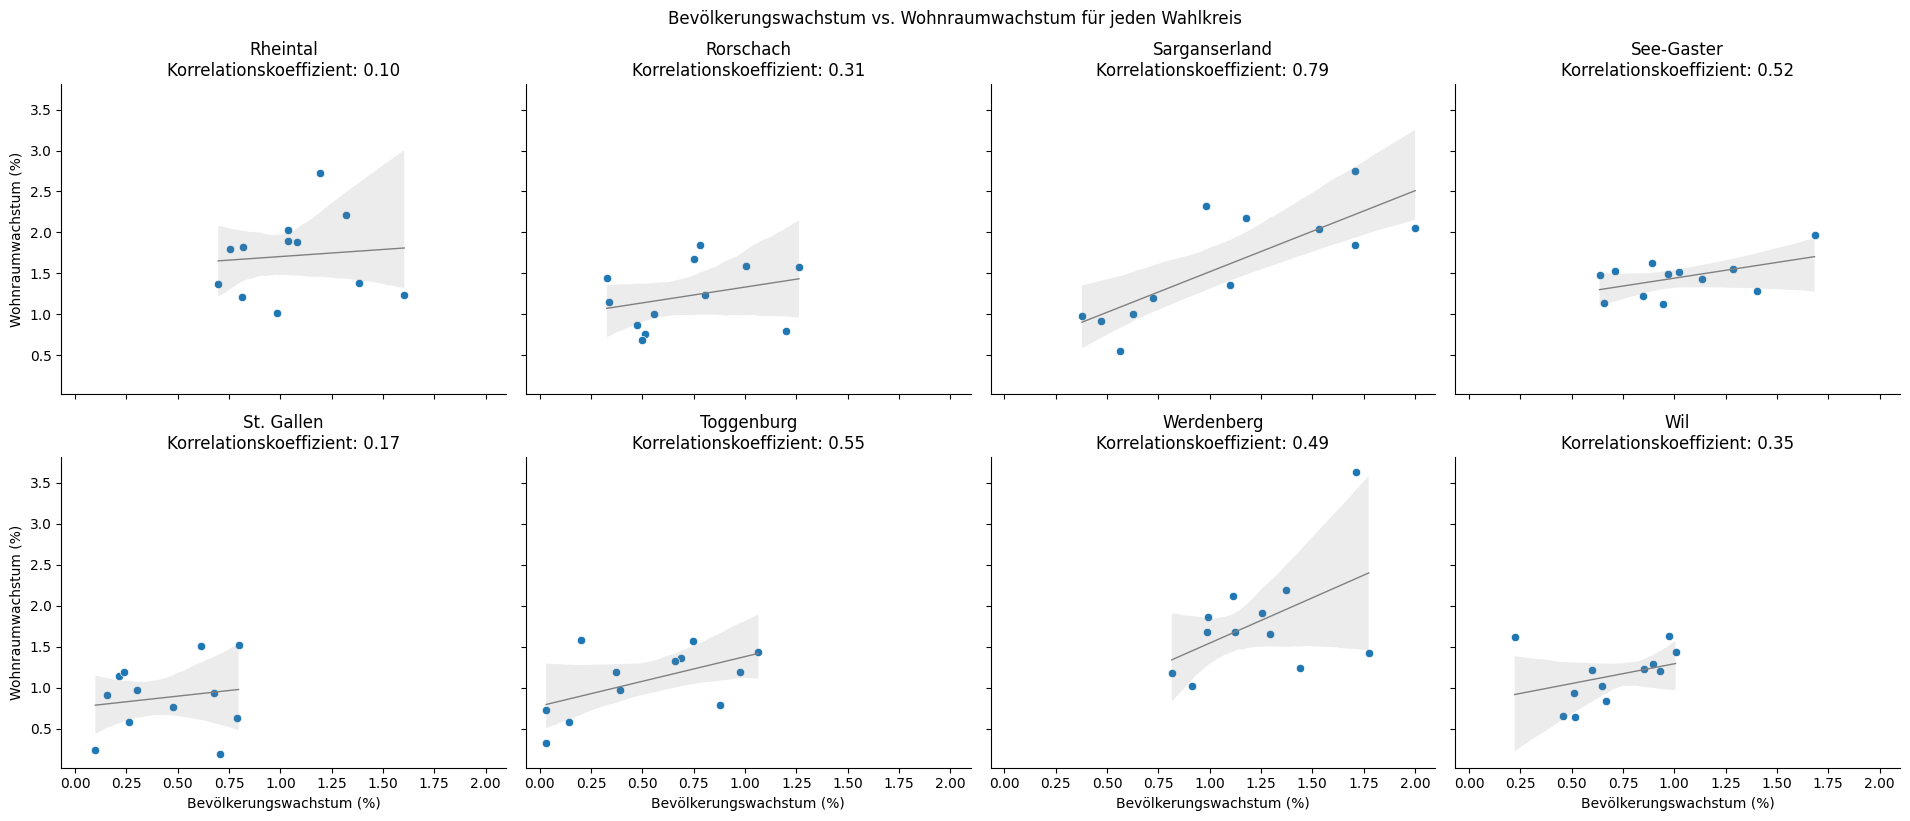

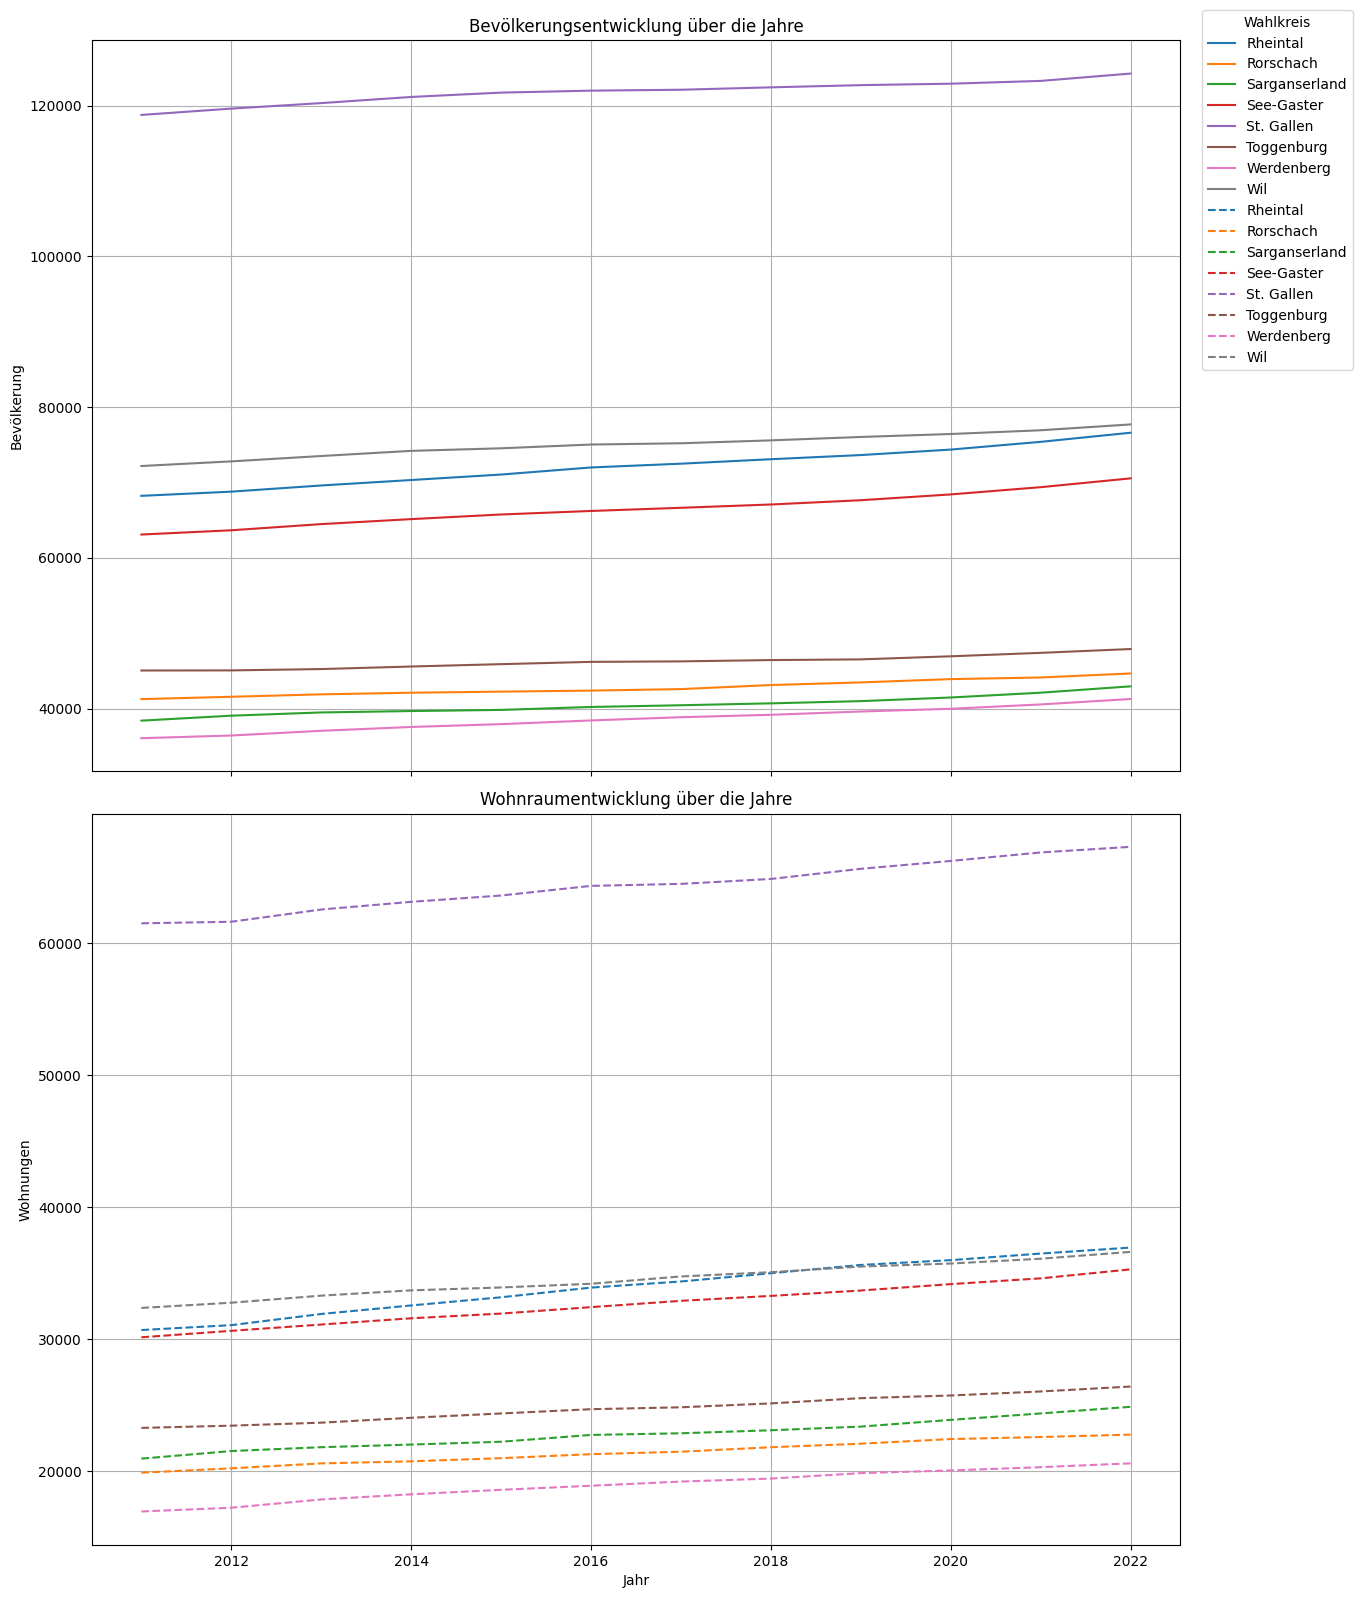

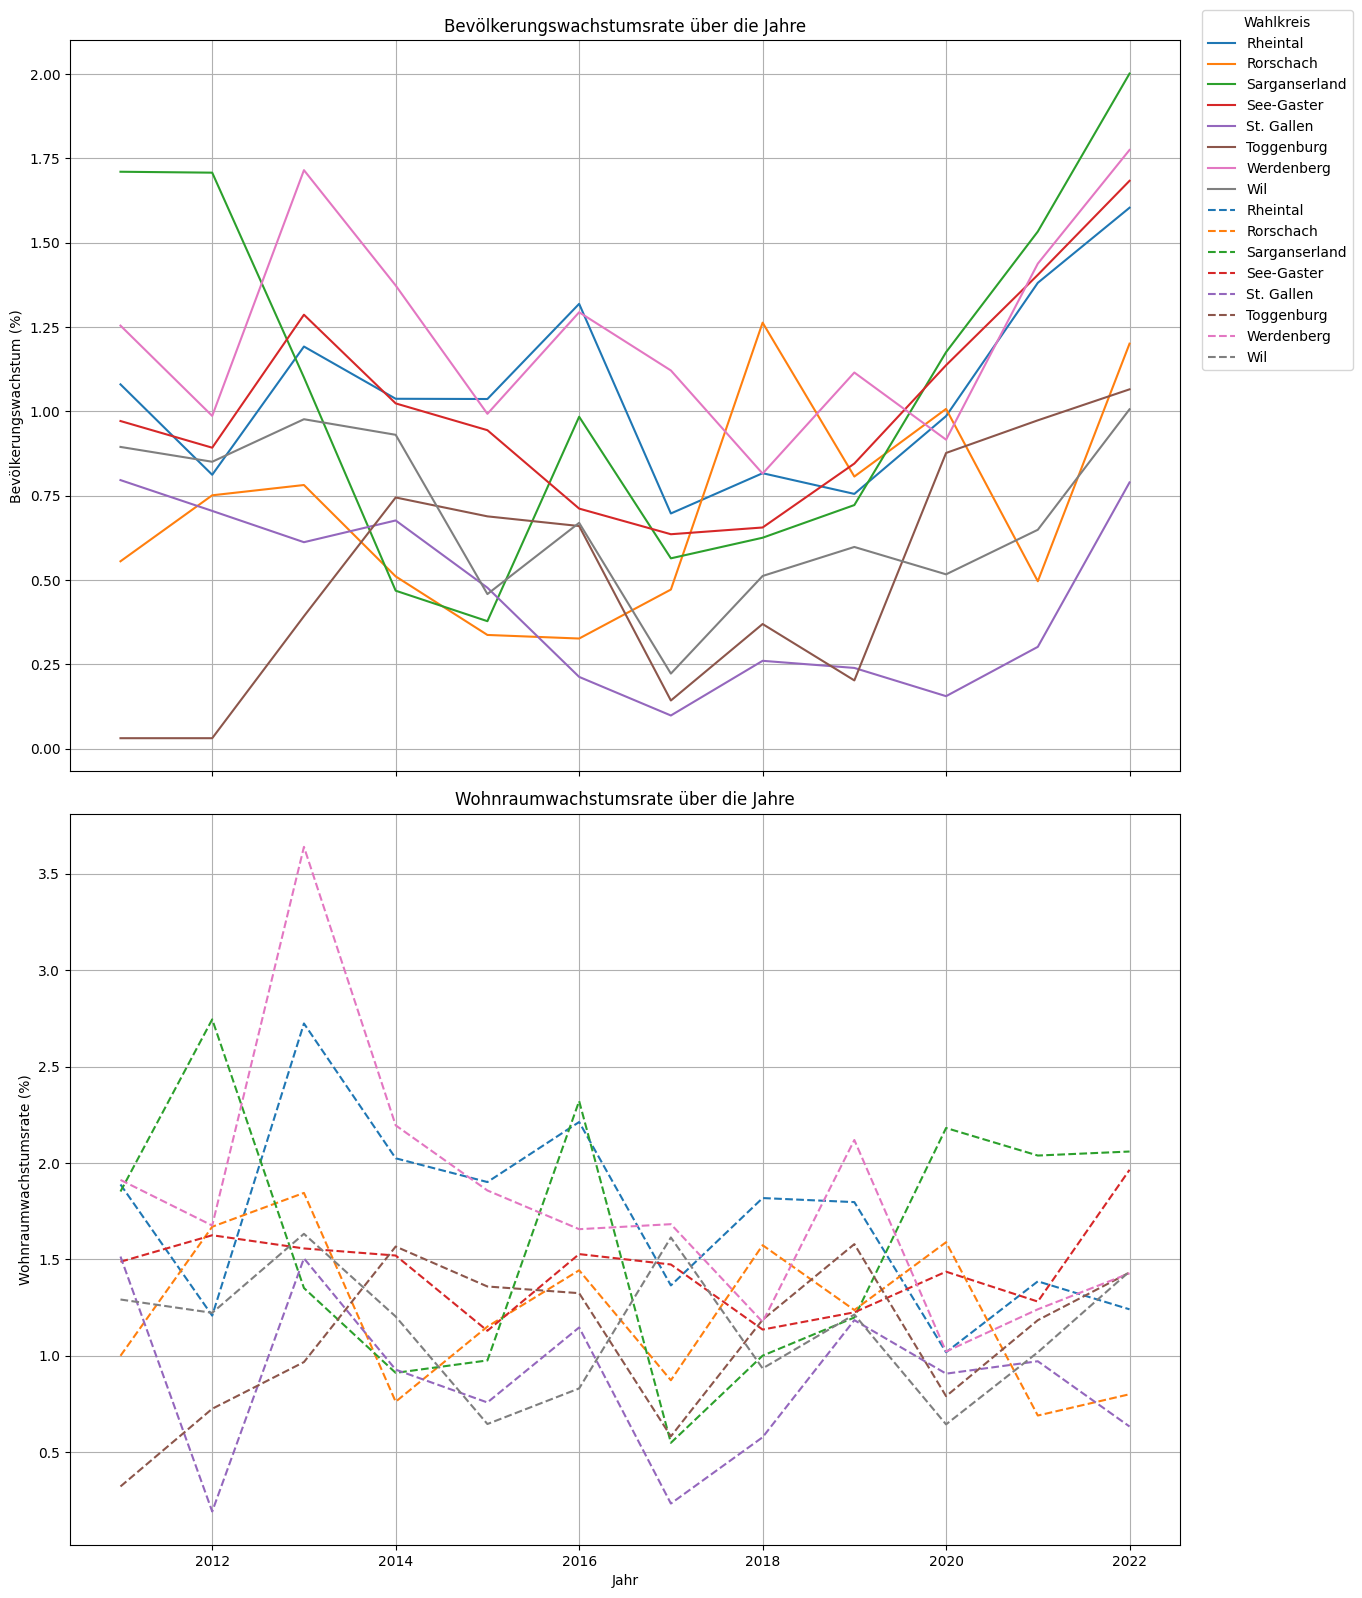

In [69]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

# Load data
population_df = load_data('ständige_wohnbevoelkerung_wahlkreise_kt_stgallen.csv', delimiter=';')
housing_df = pd.read_csv('anzahl_wohnungen_pro_wahlkreis.csv', encoding='utf-8', delimiter=',')

# Print the first few rows of the dataframes
print("Population DataFrame head (first 10 rows):")
print(population_df.head(30))
print("\nHousing DataFrame head (first 10 rows):")
print(housing_df.head(30))

# Rename columns for clarity
population_df.rename(columns={'GEBIET_NAME': 'Wahlkreis', 'INDIKATOR_JAHR': 'Jahr', 'INDIKATOR_VALUE': 'Berechnete Bevölkerungsgrösse'}, inplace=True)

# Standardize the name "St. Gallen" in both DataFrames
population_df['Wahlkreis'] = population_df['Wahlkreis'].str.replace('Wahlkreis ', '').str.replace('St.Gallen', 'St. Gallen').str.strip()
housing_df['Wahlkreis'] = housing_df['Wahlkreis'].str.replace('St.Gallen', 'St. Gallen').str.strip()

# Create a table with Wahlkreis, Jahr, and Ständige Wohnbevölkerung (Berechnete Bevölkerungsgrösse)
population_table = population_df[['Wahlkreis', 'Jahr', 'Berechnete Bevölkerungsgrösse']]

# Calculate population growth
population_table['Bevölkerungswachstum'] = population_table.groupby('Wahlkreis')['Berechnete Bevölkerungsgrösse'].pct_change() * 100

# Print the population table with growth
print("\nPopulation Table with growth (first 10 rows):")
print(population_table.head(30))

# Reshape housing data to long format
housing_df = housing_df.melt(id_vars=['Wahlkreis'], var_name='Jahr', value_name='Wohnungen')
housing_df['Jahr'] = housing_df['Jahr'].astype(int)

# Calculate housing growth
housing_df['Wohnraumwachstum'] = housing_df.groupby('Wahlkreis')['Wohnungen'].pct_change() * 100

# Print the housing dataframe with growth
print("\nHousing DataFrame with growth (first 10 rows):")
print(housing_df.head(30))

# Ensure the order of values matches in both dataframes
population_table.sort_values(by=['Wahlkreis', 'Jahr'], inplace=True)
housing_df.sort_values(by=['Wahlkreis', 'Jahr'], inplace=True)

# Merge dataframes
population_table['Jahr'] = population_table['Jahr'].astype(int)
merged_df = pd.merge(population_table, housing_df, on=['Wahlkreis', 'Jahr'], how='inner')

# Drop NaN values
merged_df.dropna(subset=['Bevölkerungswachstum', 'Wohnraumwachstum'], inplace=True)

# Print the merged dataframe
print("\nMerged DataFrame head (first 10 rows):")
print(merged_df.head(30))

# Ensure 'St. Gallen' is present in the merged dataframe
print("\nChecking for 'St. Gallen' in merged DataFrame:")
print(merged_df[merged_df['Wahlkreis'] == 'St. Gallen'])

# Function to plot each Wahlkreis with correlation coefficient
def plot_wahlkreis(data, **kwargs):
    wahlkreis = data['Wahlkreis'].iloc[0]
    corr, _ = pearsonr(data['Bevölkerungswachstum'], data['Wohnraumwachstum'])
    sns.scatterplot(data=data, x='Bevölkerungswachstum', y='Wohnraumwachstum', **kwargs)
    sns.regplot(data=data, x='Bevölkerungswachstum', y='Wohnraumwachstum', scatter=False, color='grey', line_kws={'linewidth':1})
    plt.title(f'{wahlkreis}\nKorrelationskoeffizient: {corr:.2f}')

# Overall plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='Bevölkerungswachstum', y='Wohnraumwachstum', hue='Wahlkreis', palette='Set1', alpha=0.6, s=100)
sns.regplot(data=merged_df, x='Bevölkerungswachstum', y='Wohnraumwachstum', scatter=False, color='grey', line_kws={'linewidth':1})

# Calculate and display the overall correlation coefficient
overall_corr, _ = pearsonr(merged_df['Bevölkerungswachstum'], merged_df['Wohnraumwachstum'])
plt.title(f'Bevölkerungswachstum vs. Wohnraumwachstum\nKorrelationskoeffizient: {overall_corr:.2f}')
plt.xlabel('Bevölkerungswachstum (%)')
plt.ylabel('Wohnraumwachstum (%)')
plt.grid(True)
plt.legend(title='Wahlkreis')
plt.show()

# FacetGrid for each Wahlkreis
g = sns.FacetGrid(merged_df, col='Wahlkreis', col_wrap=4, height=4, aspect=1.2)
g.map_dataframe(plot_wahlkreis)
g.set_axis_labels('Bevölkerungswachstum (%)', 'Wohnraumwachstum (%)')
g.fig.suptitle('Bevölkerungswachstum vs. Wohnraumwachstum für jeden Wahlkreis', y=1.02)
plt.show()

# Zeitreihenanalyse: Separate Plots for Population and Housing
fig, axes = plt.subplots(2, 1, figsize=(12, 16), sharex=True)
for wahlkreis in merged_df['Wahlkreis'].unique():
    df = merged_df[merged_df['Wahlkreis'] == wahlkreis]
    axes[0].plot(df['Jahr'], df['Berechnete Bevölkerungsgrösse'], label=wahlkreis)
    axes[1].plot(df['Jahr'], df['Wohnungen'], label=wahlkreis, linestyle='--')
axes[0].set_ylabel('Bevölkerung')
axes[0].set_title('Bevölkerungsentwicklung über die Jahre')
axes[1].set_ylabel('Wohnungen')
axes[1].set_title('Wohnraumentwicklung über die Jahre')
axes[1].set_xlabel('Jahr')
axes[0].grid(True)
axes[1].grid(True)
fig.legend(title='Wahlkreis', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()

# Growth Rates: Separate Plots for Population and Housing Growth Rates
fig, axes = plt.subplots(2, 1, figsize=(12, 16), sharex=True)
for wahlkreis in merged_df['Wahlkreis'].unique():
    df = merged_df[merged_df['Wahlkreis'] == wahlkreis]
    axes[0].plot(df['Jahr'], df['Bevölkerungswachstum'], label=wahlkreis)
    axes[1].plot(df['Jahr'], df['Wohnraumwachstum'], label=wahlkreis, linestyle='--')
axes[0].set_ylabel('Bevölkerungswachstum (%)')
axes[0].set_title('Bevölkerungswachstumsrate über die Jahre')
axes[1].set_ylabel('Wohnraumwachstumsrate (%)')
axes[1].set_title('Wohnraumwachstumsrate über die Jahre')
axes[1].set_xlabel('Jahr')
axes[0].grid(True)
axes[1].grid(True)
fig.legend(title='Wahlkreis', loc='upper left', bbox_to_anchor=(1,1))
plt.tight_layout()
plt.show()
